### Read-depth as a Covariate

The output from most genomics experiments (ChIP-seq, ATAC-seq, etc) is a set of reads that can be mapped to a reference genome. Usually, before use these reads are then converted to tracks that encode the number of reads that map to each position in the genome. Potentially, these tracks are subsequently processed to produce other signal values such as fold change versus a control or -log10 p-values from a peak caller. However, all of these outputs can be confounded by a simple value: the read-depth of the experiment. In this notebook we will produce a simple visualizing demonstrating this effect.

In [1]:
import matplotlib
matplotlib.use('pdf')
%matplotlib inline

import numpy
import pandas
import pyBigWig
import seaborn; seaborn.set_style('whitegrid')
import matplotlib.pyplot as plt

We've started by collecting data from the ENCODE Portal measuring H3K27ac in smooth muscle cells that originated from H9 (ENCODE Accession: ENCSR210ZPC). We downloaded the two signal bams and the two control bams for that experiment and re-ran the ENCODE ChIP-seq pipeline using them as input with the default parameters, except that we also subsampled the read-depth of the signal bams to between 10M and 60M reads. After processing, we end up with peak calls and -log10 p-values from MACS for each read-depth. You can download the processed files from Zenodo using the code below.

In [2]:
!wget -nc https://zenodo.org/record/5518246/files/h3k27ac.10M.bw
!wget -nc https://zenodo.org/record/5518246/files/h3k27ac.20M.bw
!wget -nc https://zenodo.org/record/5518246/files/h3k27ac.30M.bw
!wget -nc https://zenodo.org/record/5518246/files/h3k27ac.40M.bw
!wget -nc https://zenodo.org/record/5518246/files/h3k27ac.50M.bw
!wget -nc https://zenodo.org/record/5518246/files/h3k27ac.60M.bw
!wget -nc https://zenodo.org/record/5518246/files/overlap.optimal_peak.narrowPeak.gz

File ‘h3k27ac.10M.bw’ already there; not retrieving.

File ‘h3k27ac.20M.bw’ already there; not retrieving.

File ‘h3k27ac.30M.bw’ already there; not retrieving.

File ‘h3k27ac.40M.bw’ already there; not retrieving.

File ‘h3k27ac.50M.bw’ already there; not retrieving.

File ‘h3k27ac.60M.bw’ already there; not retrieving.

File ‘overlap.optimal_peak.narrowPeak.gz’ already there; not retrieving.



Let's start off by loading chr17 from each of the subsampled data set bigwigs. 

In [3]:
bw_filename = "h3k27ac.{}M.bw"
tracks = []

read_depths = 10, 20, 30, 40, 50, 60
for reads in read_depths:
    filename = bw_filename.format(reads)
    bw = pyBigWig.open(filename)
    track = bw.values('chr17', 0, -1)
    track = numpy.nan_to_num(track)
    tracks.append(track)

Now, let's go through the peak file and, for each peak, get the maximum signal value in the peak for each of the six subsampled depths. To make things consistent, let's use the peak file from the lowest depth data set. This makes it more likely that each called peak is actually a peak.

In [4]:
col_names = ['chrom', 'start', 'end']
peak_filename = "overlap.optimal_peak.narrowPeak.gz"
peaks = pandas.read_csv(peak_filename, sep='\t', header=None, names=col_names, usecols=(0, 1, 2))

peak_vals = []
for reads in read_depths:
    filename = bw_filename.format(reads)
    bw = pyBigWig.open(filename)
    peak_vals.append([])
    
    for i, (chrom, start, end) in peaks.iterrows():
        peak_max = numpy.max(bw.values(chrom, start, end)) 
        peak_vals[-1].append(peak_max)

Finally, let's visualize the data.

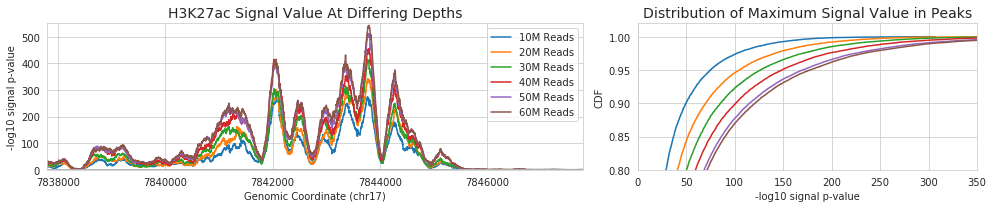

In [5]:
from matplotlib.gridspec import GridSpec

gs = GridSpec(nrows=1, ncols=5)

mid = tracks[-1].argmax()
start, end = mid - 6000, mid + 4000

plt.figure(figsize=(14, 3))
plt.subplot(gs[:3])
plt.title("H3K27ac Signal Value At Differing Depths", fontsize=14)
for i in range(6):
    plt.plot(range(start, end), tracks[i][start:end], label="{}M Reads".format(read_depths[i]))
plt.plot(range(start, end), numpy.zeros(end-start), color='0.7')
plt.legend(fontsize=10)
plt.ylabel("-log10 signal p-value")
plt.xlabel("Genomic Coordinate (chr17)")
plt.ylim(0, 550)
plt.xlim(start, end)

plt.subplot(gs[3:])
for i in range(6):
    x = peak_vals[i]
    plt.plot(sorted(x), numpy.arange(len(x)) / len(x))

plt.title("Distribution of Maximum Signal Value in Peaks", fontsize=14)
plt.xlabel("-log10 signal p-value")
plt.ylabel("CDF")
plt.ylim(0.8, 1.02)
plt.xlim(0, 350)

plt.tight_layout()
plt.savefig("nrg_fig_read-depth.pdf")

Let's start off with the left panel. Here, we're plotting the signal at one locus for each of the subsampled bigwigs. We can see that the signal is higher for experiments that have a higher read-depth. This finding isn't entirely surprising: more total reads means more reads mapped to each position on average. Even the processed data shows this effect. But, importantly, when dealing with the -log10 p-value tracks, this effect is not linear. There are some positions where the effect is more pronounced.

Next, we can look at the distributions of maximum signal values in the form of CDFs. Remember that these distributions are over the maximum signal value of a peak across all peaks in the genome. We can see that the higher the read-depth of the experiment, the more to the right the line is shifted. This means that there are more peaks with higher values as the read-depth is increased.

What is the consequence of this finding? Well, an obvious one is that machine learning analyses can be easily confounded by read-depth when multiple experiments are being used that have different read depths. If one trains a machine learning model to predict some signal in one cell type and then evaluates it's ability to make that prediction in another cell type, the predictions may be systematically off if the training cell type has a different read depth than the evaluation one. This must be corrected for by either developing a training process that incorporates the read depth explicitly or by reprocessing the data to incorporate read depth.